In [2]:
import numpy as np
import cv2 as cv
import math
import random
from collections import Counter
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt


In [3]:
class Forest:
    def __init__(
        self,
        size,
        indiviual_reward_importance,
        social_reward_importance,
        p_change_wind,
        type_plane,
        P_burn,
        P_set_fire,
        P_fire_depend_on_wind,
    ):
        self.indiviual_reward_importance = indiviual_reward_importance  # int
        self.social_reward_importance = social_reward_importance  # int
        self.grid_env = np.zeros((size, size))  # 0: safe, 1: on fire, 2:burnt
        self.grid_type = np.zeros(
            (size, size)
        )  # -1: station, 0: non_tree, 1: tree, 2: home
        self.init_grid(type_plane)
        self.wind_strength = 1
        self.wind_direction = 0  # four direction
        self.p_change_wind = p_change_wind  # 0 or 0.0001
        self.change_wind()
        self.P_burn = P_burn  # on fire=>burntd
        self.P_set_fire = P_set_fire  # neighbourhood on fire
        self.P_fire_depend_on_wind = (
            P_fire_depend_on_wind  # neighbour on fire != direction wind => +, else =>-
        )

        self.episode = []
        self.type_plane = type_plane
        self.burnt_trees = 0
        self.fired_trees = 0
        self.init_fire(1)

    #  ! This method generated plateau it takes type plane which specifies the type of plane
    # ! and the probability of each type of plane [[0,1,2],[p(0),p(1),p(2)]]

    def init_grid(self, type_plane):
        # * -1: station, 0: non_tree, 1: tree, 2: home

        m = len(self.grid_type)

        station_position = [
            np.random.choice(range(m)),
            np.random.choice(range(m)),
        ]

        # * station position has been decided at random for each episode

        for i in range(m):
            for j in range(m):
                self.grid_type[i][j] = np.random.choice(type_plane[0], p=type_plane[1])
        winSize = 1
        for i in range(m - 2 * winSize):
            for j in range(m - 2 * winSize):
                self.grid_type[i + winSize][j + winSize] = int(
                    np.mean(self.grid_type[i : i + 2 * winSize, j : j + 2 * winSize])
                )
        self.grid_type[station_position[0]][station_position[1]] = -1
        # print(self.grid_type)
        return self.grid_type

    # ! this function changes wind direction as well as speed we will change wind direction after each episode, wind direction can deviate 20% in each direction

    def change_wind(self):
        # *Output : self.wind_strength, self.wind_direction
        # *Choose the wind direction and its strenghth randomly.
        # *0 : Right , 1 : Up , 2 : left , 3 : Down

        self.wind_direction = random.choice([0, 1, 2, 3])
        self.wind_strength += random.uniform(-0.2, 0.2) * self.wind_strength
        self.wind_strength = float("{:.3f}".format(self.wind_strength))
        return self.wind_strength, self.wind_direction

    # TODO to optimise this function
    # ! Just returns the neighbours of given node

    def neighbours(self, i, j):
        # * it reresents each neighbour as dictionary where 0 ,1 , 2 ,3 reperesents directions
        # *0 : Right , 1 : Up , 2 : left , 3 : Down (i is columns and j is row)

        neighbours = {
            "0": (i, j + 1),
            "1": (i - 1, j),
            "2": (i, j - 1),
            "3": (i + 1, j),
        }
        if i == 0 and j == 0:
            neighbours = {"0": (i, j + 1), "3": (i + 1, j)}
        elif i == 0 and j == self.grid_env.shape[0] - 1:
            neighbours = {"2": (i, j - 1), "3": (i + 1, j)}
        elif i == self.grid_env.shape[0] - 1 and j == 0:
            neighbours = {"0": (i, j + 1), "1": (i - 1, j)}
        elif i == self.grid_env.shape[0] - 1 and j == self.grid_env.shape[0] - 1:
            neighbours = {"1": (i - 1, j), "2": (i, j - 1)}
        elif i == 0:
            neighbours = {"0": (i, j + 1), "2": (i, j - 1), "3": (i + 1, j)}
        elif i == self.grid_env.shape[0] - 1:
            neighbours = {"0": (i, j + 1), "1": (i - 1, j), "2": (i, j - 1)}
        elif j == 0:
            neighbours = {"0": (i, j + 1), "1": (i - 1, j), "3": (i + 1, j)}
        elif j == self.grid_env.shape[0] - 1:
            neighbours = {"1": (i - 1, j), "2": (i, j - 1), "3": (i + 1, j)}
        return neighbours

    # ! A function to start fire init point number is just the no of points where fire will be lightned

    def init_fire(self, init_point_number):  # return mean position
        # * random between 1 to 4
        # * check not station and none_tree

        points = []
        size = self.grid_env.shape[0]
        for i in range(init_point_number):
            flag = True
            while flag:
                X1 = np.random.choice(range(size))
                X2 = np.random.choice(range(size))
                if self.grid_type[X1][X2] >= 1:
                    points.append((X1, X2))
                    break
            self.grid_env[X1][X2] = 1
            neighbours = list(self.neighbours(X1, X2).values())
            for i in neighbours:
                self.grid_env[i[0]][i[1]] = 1
        return points

    # ! returns neighbours in fire and their direction It just returns the neightbours which are on fire but
    # ! not returns the absolute coordinate but returns the direction ie either [0,2] ie which neighbours

    def get_neighbours_on_fire(self, grid_env, point):
        on_fires_direction = []
        # * 0 : Right || 1 :Up || 2 : Left || 3 : Down
        i = point[0]
        j = point[1]
        neighbours = self.neighbours(i, j)
        for n in range(len(neighbours)):
            neighbour = list(neighbours.values())[n]
            direction = list(neighbours.keys())[n]
            if grid_env[neighbour[0]][neighbour[1]]:
                on_fires_direction.append(int(direction))
        return on_fires_direction

    # ! Reset the game for next episode

    def reset(self):  # init
        size = self.grid_env.shape[0]
        self.wind_strength = 0
        self.wind_direction = 0
        self.episode = []
        self.grid_env = np.zeros((size, size))
        self.grid_type = np.zeros((size, size))
        self.init_grid(self.type_plane)
        self.change_wind()
        self.init_fire(1)

    # ? Simulation functions

    # TODO Wrong code
    # ! It will take list of neighboursa and adjust probablity based on fire direction ie on fire direction
    # ! It is more likely to spread the fire
    def get_p_fire(self, alpha, neighbours_on_fire):
        """
        input : gets neighbours on fire and their direction
        output: calculate p_fire base on wind direction
        """
        p_fire = 1
        higher_alpha = 0.9
        for i in neighbours_on_fire:
            if i == self.wind_direction:
                p_fire = p_fire * higher_alpha
            else:
                p_fire = p_fire * alpha
        return p_fire

    # ! Main simulation function which changes the states
    # * burnt states are not transitioned
    # * If a given node has its neighbours on fire then this node will have a prob to be set on fire
    # TODO First of all descrese time complexity of grid updating , second need to upgrade the model
    # To discuss new model of fire updation

    # * Working for every node we see which neighbours are on fire and then update current node according to prob

    def P_transitions(self):
        alpha = 0.7  # * prob to be set on fire opposite to wind direction
        size = self.grid_env.shape
        copy_env = np.zeros(size) + self.grid_env
        for i in range(size[0]):
            for j in range(size[1]):
                on_fire_neighbours = self.get_neighbours_on_fire(copy_env, (i, j))
                if copy_env[i][j] == 0:
                    if self.grid_type[i][j] != -1 and self.grid_type[i][j] != 0:
                        p_fire = self.get_p_fire(alpha, on_fire_neighbours)
                        # alpha based on wind direction
                        # 0 : Right , 1 : Up , 2 : left , 3 : Down
                        new_state = np.random.choice([0, 1], p=[p_fire, 1 - p_fire])
                        self.grid_env[i][j] = new_state
                elif copy_env[i][j] == 1:
                    newstate = np.random.choice(
                        [1, 2], p=[1 - self.P_burn, self.P_burn]
                    )
                    self.grid_env[i][j] = newstate
                    if newstate == 2:
                        neighbours = list(self.neighbours(i, j).values())
                        for n in neighbours:
                            if self.grid_env[n] == 0 and self.grid_type[i][j] > 0:
                                self.grid_env[n] = 1
                                break

    # ! returns no of trees burnt between and no of trees caught fire between two states
    # TODO my inference is that this is calculating burnt trees in wrong way

    def get_env_give_tree(self, first_env, second_env):
        safe_counter, new_safe_counter = 0, 0
        burnt_counter, new_burnt_counter = 0, 0
        for i in range(first_env.shape[0]):
            for j in range(first_env.shape[1]):
                if first_env[i][j] == 0:
                    safe_counter += 1
                elif first_env[i][j] == 2:
                    burnt_counter += 1
        for i in range(first_env.shape[0]):
            for j in range(first_env.shape[1]):
                if second_env[i][j] == 0:
                    new_safe_counter += 1
                elif second_env[i][j] == 2:
                    new_burnt_counter += 1
        # * Safe counter is the number of healthy trees in a state
        # * burnt_counter is no of trees completely burnt in a state
        burnt_trees = new_burnt_counter - burnt_counter
        fired_trees = safe_counter - new_safe_counter
        return burnt_trees, fired_trees

    # ! returns weather current cell is at border or not
    # TODO wrong implementation
    def is_border(self, x, y):
        # * This function get the position of the agent and return True if there is one safe tree or home grid with manhatan distance = 1
        is_border = False
        neighbors = list(self.neighbours(x, y).values())
        # 0: safe, 1: on fire, 2:burnt
        if self.grid_env[x, y] != 1:
            return is_border
        for neigh in neighbors:
            if self.grid_env[neigh] == 0 and self.grid_type[neigh] > 0:
                is_border = True
                break
        return is_border

    # ! This function takes action and postion of agent as input and computes next state
    def next_state(self, action, position, env_transition=True):
        """
        Input : action : include control actions of all agents || env_transition = determine whether to change environment based on passing time
        Output: Updated self.grid_env
        Change the dynamic of environment based on agents' actions or passing time.
        """
        grid_env_p = np.copy(self.grid_env)
        if action is not None:
            for i in range(len(action)):
                x, y = position[i]
                if action[i][0] == 1 and self.grid_env[x, y] == 1:
                    self.grid_env[x, y] = 0

        if env_transition:
            # call P_transition method
            self.P_transitions()
            # for idx, x in np.ndenumerate(self.grid_env):
            #     if x ==  0:
            #         self.grid_env[idx] = random.choices([0,1,2],weights = self.P_transition[0,:])[0]
            #     elif x == 1:
            #         self.grid_env[idx] = random.choices([0,1,2],weights = self.P_transition[1,:])[0]
        # self.burnt_trees, self.fired_trees = self.get_env_give_tree(grid_env_p, self.grid_env)
        return self.grid_env

    # ! Reward calculation function for all agents based on their actions and positions
    # TODO wrong implementation (why?) environment is considered deterministic

    def calculate_reward(self, action, position):
        # state=[3X3],[3X3],x,y,mean_x_fire,mean_y_fire
        # Action: fire_r => 0,1 , move => 0,...,8, help => 0,1, =>[[0,1],[0,...,8],[0,1]]
        # individual: collision => -- , healthy retardant => -, on_fire on border=> ++, on_fire=>+,
        # social: for each new burnt tree=>-, for each new burnt home=>--,
        # action = fire_retardant:
        # ind_r = if home: on_fire => safe => 3*r1
        #         elif tree: on_fire => safe => 2*r1
        #         elif   station or non_tree => -2*r1
        #         border(at least one neigh safe and not non_tree): on_fire => safe => r1
        # move => if collision: -10*r1
        # help => -10*r1

        r1 = 5
        new_position = position
        ind_r = np.zeros((len(action), 1))
        social_r = np.zeros((len(action), 1))
        num_rep_pos = dict(Counter(new_position))
        for i in range(len(action)):
            x, y = position[i]
            if action[i][0] == 1:
                if self.grid_env[x, y] == 0 or self.grid_env[x, y] == 2:
                    ind_r[i, :] -= r1
                    if self.grid_type[x, y] == -1 or self.grid_type[x, y] == 0:
                        ind_r[i, :] -= r1

                else:
                    if self.grid_type[x, y] == 1:
                        ind_r[i, :] += 2 * r1
                    elif self.grid_type[x, y] == 2:
                        ind_r[i, :] += 3 * r1
                    if self.is_border(x, y) == True:
                        ind_r[i, :] += r1
                ind_r[i, :] += 10 * r1
            if num_rep_pos[new_position[i]] > 1:
                ind_r[i, :] -= 10 * r1
            if action[i][2] == 1:
                ind_r[i, :] -= 10 * r1
            social_r[i, :] = -1 * r1 * self.burnt_trees - 1 * r1 * self.fired_trees

        # social_r:
        # -1*#new_burnt -1*#new_home_burnt -1*#new_on_fire -1*#new_home_on_fire
        # returns self.indiviual_reward_importance* ind_r + self.social_reward_importance * social_r for each agent

        total_r = (
            self.indiviual_reward_importance * ind_r
            + self.social_reward_importance * social_r
        )

        # print("ind reward : ", ind_r)
        # print("social reward : ", social_r)
        return total_r

    # ! returns flase if any one on fire otherwise true
    # TODO can  be integrated into p transitons
    def terminated(self):  # no on fire
        terminated = True
        for i in range(self.grid_env.shape[0]):
            for j in range(self.grid_env.shape[0]):
                if self.grid_env[i][j] == 1:
                    terminated = False
                    break
        return terminated

    # # ! returns the view of single agent it is lXw grid around agent
    def observe(self, l, w, position):
        """
        Input : l: length of scope of IR Camera || w : length of scope of IR Camera || postion : one Agent position
        Output : Situatuion of l*w grids in the agent scope
        A downward facing Infrared (IR) camera captures the states of an l * w sized grid of trees.
        The agent is located at the center of the image and if images are taken at an edge of the forest, the image is padded with non-trees.
        """
        assert l % 2 == 0 and w % 2 == 0, "l and w should be an even integer"
        x, y = position
        X, Y = self.grid_env.shape
        X = X - 1
        Y = Y - 1
        dpad_x = max(int(x + l / 2) - X, 0)
        upad_x = max(0 - int(x - l / 2), 0)
        rpad_y = max(int(y + w / 2) - Y, 0)
        lpad_y = max(0 - int(y - w / 2), 0)
        # print(lpad_y,rpad_y,upad_x,dpad_x)
        grid1 = np.pad(
            self.grid_env,
            ((upad_x, dpad_x), (lpad_y, rpad_y)),
            "constant",
            constant_values=0,
        )
        grid2 = np.pad(
            self.grid_type,
            ((upad_x, dpad_x), (lpad_y, rpad_y)),
            "constant",
            constant_values=0,
        )
        # print(int(x- l/2)+upad_x,int(x + l/2)+upad_x+1,int(y-w/2)+lpad_y, int(y+w/2)+lpad_y+1)
        # print("Grid",grid1.shape,grid2.shape)
        return (
            grid1[
                int(x - l / 2) + upad_x : int(x + l / 2) + upad_x + 1,
                int(y - w / 2) + lpad_y : int(y + w / 2) + lpad_y + 1,
            ],
            grid2[
                int(x - l / 2) + upad_x : int(x + l / 2) + upad_x + 1,
                int(y - w / 2) + lpad_y : int(y + w / 2) + lpad_y + 1,
            ],
        )
    
    # ! takes ations and positions of agents and returns reward , episode over and observation for each agent
    def step(self, action, position):
        self.next_state(action, position)
        r = self.calculate_reward(action, position)
        obsv = []
        for p in position:
            obsv.append(self.observe(2, 2, p))
        return r, self.terminated(), obsv
    

    # ! returns mean position of fire
    def mean_fire_pos(self):
        fire_pos = []
        for idx in range(len(self.grid_env)):
            for idx2 in range(len(self.grid_env)):
                if self.grid_env[idx][idx2] == 1:
                    fire_pos.append(np.array([idx, idx2]))
        if len(np.array(fire_pos)) == 0:
            return 0, 0
        a = np.average(np.array(fire_pos), axis=0)
        return int(a[0]), int(a[1])

    # ? utilities for rendering and saving episodes
    # TODO implement again using pygame library

    def render(self, agents_position):  # opencv, show state, show info
        m = len(self.grid_type)
        pad = 10
        img = np.zeros((m * pad + pad, m * pad, 3), np.uint8)
        for i in range(m):
            for j in range(m):
                if self.grid_env[i][j] == 0:
                    if self.grid_type[i][j] == 2:
                        c = (190, 0, 0)
                    elif self.grid_type[i][j] == -1:
                        c = (0, 240, 240)
                    elif self.grid_type[i][j] == 1:
                        c = (0, 190, 0)
                    else:
                        c = (30, 105, 210)
                elif self.grid_env[i][j] == 1:
                    c = (0, 0, 247)
                else:
                    c = (0, 0, 0)
                img[i * pad : (i + 1) * pad, j * pad : (j + 1) * pad] = c
        font = cv.FONT_HERSHEY_SIMPLEX
        bottomLeftCornerOfText = (0, m * pad + pad)
        fontScale = 1
        fontColor = (255, 255, 255)
        lineType = 2
        txt = (
            "Wind Direction:"
            + str(self.wind_direction)
            + " strength:"
            + str(self.wind_strength)
        )
        cv.putText(
            img, txt, bottomLeftCornerOfText, font, fontScale, fontColor, lineType
        )
        for a in agents_position:
            cv.circle(
                img,
                (a[0] * pad + int(pad / 2), a[1] * pad + int(pad / 2)),
                int(pad / 2),
                (255, 0, 255),
                -1,
            )
        cv.imwrite("T.jpg", img)
        self.episode.append(img)
        self.episode.append(img)
        self.episode.append(img)

    def save_episode(self):  # save episode to video
        m = len(self.grid_type)
        pad = 10
        frameSize = (m * pad + pad, m * pad)
        video_path = "out.avi"
        height, width, channels = self.episode[0].shape
        video = cv.VideoWriter(
            video_path, cv.VideoWriter_fourcc(*"DIVX"), 10, (width, height)
        )
        for img in self.episode:
            video.write(img)

        cv.destroyAllWindows()
        video.release()
        print("video saved")


In [4]:
f = Forest(
    size=20,
    indiviual_reward_importance=5,
    social_reward_importance=2,
    p_change_wind=0,
    type_plane=[[0, 1, 2], [0.005, 0.9, 0.095]],
    P_burn=0.1,
    P_set_fire=0.1,
    P_fire_depend_on_wind=0.1,
)


### Deep neural netwrok for training

In [5]:
class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions):
        super(DeepQNetwork, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_dims,fc1_dims),
            nn.ReLU(inplace=True),
            nn.Linear(fc1_dims, fc2_dims),
            nn.ReLU(inplace=True),
            nn.Linear(fc2_dims, n_actions),
        )

    def forward(self, features):
        return self.network(features.float())


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from collections import defaultdict
import copy
import numpy as np
import os
import sys
import time


In [7]:
class mini_Agent:
    def __init__(
        self,
        id,
        level,
        parent,
        env,
        read=None,
        input_dims=22,
        n_actions=36,
        batch_size=16,
        gamma=0.9,
        epsilon=0.9,
        lr=0.1,
        max_mem_size=10000,
        eps_end=0.05,
        eps_dec=5e-4,
    ):
        self.model = DeepQNetwork(
            lr, n_actions=n_actions, input_dims=input_dims, fc1_dims=128, fc2_dims=128
        )
        self.target = DeepQNetwork(
            lr, n_actions=n_actions, input_dims=input_dims, fc1_dims=128, fc2_dims=128
        )
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

        self.sars = None
        self.eps = 1
        self.reward_history = []
        self.loss_history = []
        self.num_train_episodes = 0
        self.print_enough_experiences = False

        self.id = id
        self.level = level
        self.n_actions = n_actions
        self.parent = parent
        # random ?? np.array or tuple ??
        size = env.grid_env.shape[0]
        x = random.randint(0, size - 1)
        y = random.randint(0, size - 1)
        self.position = (x, y)
        # Broadcast ??
        mean_x_fire, mean_y_fire = env.mean_fire_pos()
        self.mean_pos_fire = (mean_x_fire, mean_y_fire)

        self.observ1, self.observ2 = env.observe(2, 2, self.position)
        self.observ = [self.observ1, self.observ2, self.position, self.mean_pos_fire]
        self.best_SARS = [self.observ, [0, 0, 0], 0, self.observ, 0]
        self.action_list = []
        for i in range(2):
            for j in range(9):
                for k in range(2):
                    self.action_list.append([i, j, k])
        # id,memory,...
        # position
        # meanx, meany
        # best_state_action_R
        self.action_space = range(n_actions)
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.past_position = (0, 0)
        self.configdtype = torch.tensor
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.replace_target = 4
        self.min_exp = 10
        self.loss_fn = nn.MSELoss(reduction="mean")
        self.input_dims = input_dims
        self.model_updates = 0
        if read is not None:
            self.load_checkpoint(read)
        """
        self.mem_cntr = 0
        self.iter_cntr = 0
        # n_actions,input_dims in the input ??
        self.Q_eval = DeepQNetwork(lr, n_actions=n_actions, input_dims=input_dims,
                                    fc1_dims=128, fc2_dims=128)
        self.Q_next = DeepQNetwork(lr, n_actions=n_actions, input_dims=input_dims,
                                    fc1_dims=64, fc2_dims=64)
                            
        self.state_memory = np.zeros((self.mem_size, input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, input_dims), dtype=np.float32)
        self.action_memory = np.zeros((self.mem_size,n_actions), dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)"""

    def save_checkpoint(self):
        checkpoint = {
            "state_dict": self.model.state_dict(),
            "target_dict": self.target.state_dict(),
            "optimizer": self.optimizer.state_dict(),
            "replay": self.sars,
            "epsilon": self.eps,
            "reward_history": self.reward_history,
            "loss_history": self.loss_history,
            "num_train_episodes": self.num_train_episodes,
        }
        filename = "madqn-" + str(self.id) + ".pth.tar"
        torch.save(checkpoint, filename)

    def load_checkpoint(self, id):
        filename = "madqn-" + str(id) + ".pth.tar"
        checkpoint = torch.load(filename)
        self.model.load_state_dict(checkpoint["state_dict"])

        self.target.load_state_dict(checkpoint["target_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer"])
        self.sars = checkpoint["replay"]
        self.eps = checkpoint["epsilon"]
        self.reward_history = checkpoint["reward_history"]
        self.loss_history = checkpoint["loss_history"]
        self.num_train_episodes = checkpoint["num_train_episodes"]

    def store_transition(self, state, action, reward, state_, terminal):
        # print("store_transition")
        l = list(np.array(state[0]).flatten().astype(int)) + list(
            np.array(state[1]).flatten().astype(int)
        )
        # print("store", state)
        l.append(int(state[2][0]))
        l.append(int(state[2][1]))
        l.append(int(state[3][0]))
        l.append(int(state[3][1]))
        new_state = np.array(l)
        l = list(np.array(state_[0]).flatten().astype(int)) + list(
            np.array(state_[1]).flatten().astype(int)
        )
        l.append(int(state_[2][0]))
        l.append(int(state_[2][1]))
        l.append(int(state_[3][0]))
        l.append(int(state_[3][1]))
        new_state_ = np.array(l)
        # print("store", action)
        if len(action) > 1:
            new_action = self.action_list.index(action)
        data = np.zeros((1, 2 * len(new_state) + 1 + 1))
        data[0, 0 : len(new_state)] = new_state

        data[0, len(new_state)] = new_action
        reward_idx = len(new_state) + 1
        data[0, reward_idx] = reward
        next_features_idx = len(new_state) + 1 + 1
        data[0, next_features_idx:] = new_state_

        if self.sars is None:
            self.sars = data
        else:
            self.sars = np.vstack((self.sars, data))
        # drop from memory if too many elements
        if self.sars.shape[0] > self.mem_size:
            if self.sars.shape[0] - self.mem_size > self.batch_size:
                sars = []
                for i in range(int((self.sars.shape[0] - self.mem_size) / 2)):
                    sars.append(
                        self.sars[int((self.sars.shape[0] - self.mem_size) / 2) + i - 1]
                    )
        """
        index = self.mem_cntr % self.mem_size
        l = list(np.array(state[0]).flatten().astype(int)) + list(np.array(state[1]).flatten().astype(int))
        l.append(int(state[2][0]))
        l.append(int(state[2][1]))
        l.append(int(state[3][0]))
        l.append(int(state[3][1]))
        self.state_memory[index] = T.tensor(l).type(T.LongTensor)
        l = list(np.array(state_[0]).flatten().astype(int)) + list(np.array(state_[1]).flatten().astype(int))
        l.append(int(state_[2][0]))
        l.append(int(state_[2][1]))
        l.append(int(state_[3][0]))
        l.append(int(state_[3][1]))
        self.new_state_memory[index] = T.tensor(l).type(T.LongTensor)
        self.reward_memory[index] = reward
        #print(self.action_memory.shape)
        #print(action)
        indx = self.action_list.index(action)
        array = np.zeros(self.n_actions)
        array[indx] = 1
        self.action_memory[index] =  T.tensor(array).type(T.LongTensor)
        self.terminal_memory[index] = terminal
        self.mem_cntr += 1"""
        if self.best_SARS[2] < reward:
            self.best_SARS = [state, action, reward, state_, terminal]

    def update_Q_network(self):
        # print("updating Q net for agent"+str(self.id))
        if (
            self.sars is None
            or self.sars.shape[0] < self.min_exp
            or self.sars.shape[0] < self.batch_size
        ):
            return
        # print("in update")
        # create mini-batch
        # print("sars: ",self.sars)
        batch = self.sars[
            np.random.choice(self.sars.shape[0], self.batch_size, replace=False), :
        ]
        batch_features = torch.from_numpy(batch[:, 0 : self.input_dims])
        batch_features = Variable(batch_features.int())
        batch_actions = torch.from_numpy(batch[:, self.input_dims]).type(torch.int64)
        batch_actions = Variable(batch_actions)
        x = (
            self.model(batch_features.float())
            .gather(1, batch_actions.view(-1, 1))
            .squeeze()
        )

        # calculate loss
        batch_rewards = batch[:, self.input_dims + 1]
        next_features_idx = self.input_dims + 1 + 1
        batch_next_features = Variable(torch.from_numpy(batch[:, next_features_idx:]))
        tt = self.target(batch_next_features.float()).data.cpu().numpy()
        tt = batch_rewards + self.gamma * np.amax(tt, axis=1)
        tt = Variable(torch.from_numpy(tt).float(), requires_grad=False)
        loss = self.loss_fn(x, tt)

        self.loss_history.append(loss.item())

        # back propagate
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.epsilon = (
            self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min
        )
        if self.model_updates % self.replace_target == 0:
            self.target = copy.deepcopy(self.model)
        self.model_updates += 1

        """
        if self.mem_cntr < self.batch_size:
            return
        #print("after if")

        self.Q_eval.optimizer.zero_grad()
        
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, self.batch_size, replace=False)
        
        batch_index = np.arange(self.batch_size, dtype=np.int32)

        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)
        #????
        #print(self.Q_eval(state_batch),self.Q_eval(state_batch).shape)
        #l = self.action_list.index(action)
        #print(self.Q_eval(state_batch))
        q_eval = self.Q_eval(state_batch)[batch_index,action_batch]
        q_next = self.Q_eval(new_state_batch)
        q_next[terminal_batch] = 0.0

        q_target = reward_batch + self.gamma*T.max(q_next,dim=1)[0]

        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()
        #print("out of function")

        self.iter_cntr += 1
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min \
                       else self.eps_min"""

    def choose_action(self, observation):
        # print("choosing action for agent:"+str(self.id))
        if True:  # np.array(observation).ndim != 1:
            l = list(np.array(observation[0]).flatten().astype(int)) + list(
                np.array(observation[1]).flatten().astype(int)
            )
            l.append(float(observation[2][0]))
            l.append(float(observation[2][1]))
            l.append(float(observation[3][0]))
            l.append(float(observation[3][1]))
            observation = np.array(l)
        if np.random.random() > self.epsilon:
            q_features = Variable(torch.from_numpy(observation)).type(T.long)
            q_values = (
                self.model(torch.from_numpy(observation).float())[0].data.cpu().numpy()
            )
            action = self.action_list[np.argmax(q_values)]
        else:
            if np.random.random() > self.epsilon / 3:
                action = self.heuristic()
            else:
                action = self.action_list[
                    np.random.choice(self.action_space)
                ]  # self.action_space
        return action

    def heuristic(self):
        action = [0, 0, 0]
        # if agent reached fire, move on the fire boundary to apply retardant
        if self.observ1[1][1] == 1:
            action[0] = 1
        if True:
            # find the action that is closest to simply rotating clockwise about the fire center
            if self.position[0] < self.mean_pos_fire[0]:
                if self.position[1] < self.mean_pos_fire[1]:
                    action[1] = 2
                elif self.position[1] == self.mean_pos_fire[1]:
                    action[1] = 1
                else:
                    action[1] = 8
            elif self.position[0] == self.mean_pos_fire[0]:
                if self.position[1] < self.mean_pos_fire[1]:
                    action[1] = 3
                elif self.position[1] == self.mean_pos_fire[1]:
                    action[1] = 0
                    action[0] = 1
                else:
                    action[1] = 7
            else:
                if self.position[1] < self.mean_pos_fire[1]:
                    action[1] = 4
                elif self.position[1] == self.mean_pos_fire[1]:
                    action[1] = 5
                else:
                    action[1] = 6
            fire_center_vector = [
                self.position[0] - self.mean_pos_fire[0],
                self.position[1] - self.mean_pos_fire[1],
            ]
        return action

    # amir
    def update_state(self, observ1, observ2):
        self.observ[0] = observ1
        self.observ[1] = observ2

    # man
    def update_position(self, action_array, m):
        m = m - 1
        self.past_position = (self.position[0], self.position[1])
        position = self.position
        move = [0, 0]
        action = action_array
        if action == 1:
            move = [1, 0]
        elif action == 2:
            move = [1, 1]
        elif action == 3:
            move = [0, 1]
        elif action == 4:
            move = [-1, 1]
        elif action == 5:
            move = [-1, 0]
        elif action == 6:
            move = [-1, -1]
        elif action == 7:
            move = [0, -1]
        elif action == 8:
            move = [1, -1]
        position_new = np.array(position) + move
        if (
            position_new[0] > m
            or position_new[0] < 0
            or position_new[1] > m
            or position_new[1] < 0
        ):
            position = position
        else:
            position = (position_new[0], position_new[1])
        self.position = (position[0], position[1])


In [8]:
size = 20
indiviual_reward_importance = 0.1
social_reward_importance = 0.1
p_change_wind = 0.001
type_plane = [[0, 1, 2], [0.005, 0.9, 0.095]]
P_burn = 0.1
P_set_fire = 0.1
P_fire_depend_on_wind = 0.1


In [9]:
class Agent:
    # amir
    def __init__(self, env, arch, read=None, record_flag=False):
        # init mini_Agents =>[]
        self.counter = 1
        self.all_agents = []
        self.env = env
        self.arch = arch
        self.record_flag = record_flag
        if read is not None:
            if read == 1:
                for a in arch:
                    self.all_agents.append(
                        mini_Agent(a[0], a[2], a[1], env, a[0])
                    )  # [mini_Agent() for agent in range(agent_number)]
            else:
                for a in arch:
                    self.all_agents.append(mini_Agent(a[0], a[2], a[1], env, 0))
        else:
            for a in arch:
                self.all_agents.append(
                    mini_Agent(a[0], a[2], a[1], env)
                )  # [mini_Agent() for agent in range(agent_number)]
        # self.agents_info =
        # for mini_Agent id,level,parent [id,parent_id,level]
        #

        return

    def take_action(self, actions, positions):
        # print("taking action")
        # print(actions)
        j = 0
        for agent in self.all_agents:
            if actions[j][1] != 0:
                agent.update_position(actions[j][1], len(self.env.grid_env))
            j = j + 1
        r, terminated, observations = self.env.step(actions, positions)
        for j in range(len(self.all_agents)):
            agent = self.all_agents[j]

        # for each agent state agent update
        # for each agent if action = move => update position
        # for each agent if action == help => init new mini_Agent with Net Queen
        # returns reward, terminated
        self.counter += 1
        return r, terminated, observations

    def communicate(self, level):  # comunication: level down to up
        # define agents with level
        lev_1 = [x for x in level if x[2] == 0]
        lev_2 = [x for x in level if x[2] == 1]
        lev_3 = [x for x in level if x[2] == 2]
        all_gents_level = [lev_1, lev_2, lev_3]
        for same_level in all_gents_level:
            for agent in same_level:
                parent_i = agent[1]
                id_i = agent[0]
                agent = self.all_agents[id_i]
                mean_x_fire = self.all_agents[id_i].mean_pos_fire[0]
                mean_y_fire = self.all_agents[id_i].mean_pos_fire[1]
                counter = 0
                same_levels_for_comparison = [] + same_level
                if(agent in same_levels_for_comparison):
                    same_levels_for_comparison.remove(agent)
                while counter < len(same_levels_for_comparison):
                    new_parent = same_levels_for_comparison[counter][1]
                    new_id = same_levels_for_comparison[counter][0]
                    new_agent = self.all_agents[new_id]
                    if parent_i == new_parent:
                        agent.mean_pos_fire = (
                            int(np.mean([mean_x_fire, new_agent.mean_pos_fire[0]])),
                            int(np.mean([mean_y_fire, new_agent.mean_pos_fire[1]])),
                        )
                        # print(new_agent.best_SARS)
                        if (
                            np.sum(new_agent.best_SARS[0][0])
                            + np.sum(new_agent.best_SARS[0][1])
                            + np.sum(new_agent.best_SARS[1])
                            + np.sum(new_agent.best_SARS[2])
                            + np.sum(new_agent.best_SARS[3][0])
                            + np.sum(new_agent.best_SARS[3][1])
                            + np.sum(new_agent.best_SARS[4])
                        ) != 0:
                            agent.store_transition(
                                new_agent.best_SARS[0],
                                new_agent.best_SARS[1],
                                new_agent.best_SARS[2],
                                new_agent.best_SARS[3],
                                new_agent.best_SARS[4],
                            )
                    counter = counter + 1
        return

    def live_one_episode(self):
        # *while not terminated:
        # *      for each agent:
        # *          choose action ( action = mini_agent.choose_action(observation) )
        # *          take_action  (reward, done, obsv = env.step(action))
        # *          mini_agent.store_transition(observation, action, reward, obsv, done)
        # *          communication
        # *          mini_agent.store_transition(based on communication)
        # *          mini_agent.learn()
        # *          observation = obsv
        # *          save(score,....?)
        total_R = []
        terminated = False
        while not terminated:
            actions = []
            positions = []
            for j in range(len(self.all_agents)):
                agent = self.all_agents[j]
                actions.append(agent.choose_action(agent.observ))
                positions.append(agent.position)
            len_before = len(self.all_agents)
            # print("len before:"+str(len(self.all_agents)))
            reward, terminated, obsv = self.take_action(actions, positions)
            for j in range(len_before):
                agent = self.all_agents[j]
                # obsp = np.copy(agent.observ)
                obsp = agent.observ.copy()
                print(obsp)
                # obsp[2] = agent.past_position

                agent.observ[0] = obsv[j][0]
                agent.observ[1] = obsv[j][1]
                agent.observ[2] = agent.position
                if any(np.array(agent.observ[0]).flatten()) == 1:
                    # print(agent.mean_pos_fire[0],agent.position[0])
                    agent.mean_pos_fire = (
                        np.mean((agent.position[0], agent.mean_pos_fire[0])),
                        np.mean((agent.position[1], agent.mean_pos_fire[1])),
                    )
                    agent.observ[3] = agent.mean_pos_fire
                agent.store_transition(obsp, actions[j], reward[j], agent.observ.copy(), terminated)
            self.communicate(self.arch)
            for agent in self.all_agents:
                agent.update_Q_network()
            if self.record_flag:
                self.env.render(positions)
            total_R.append(reward)
        if self.record_flag:
            self.env.save_episode()
        return total_R

        # while not terminated
        #       for each agent choose action
        #       take_action
        #       communication
        #       for each agent update_Q_network based on reward and communication

    # communication :(mean_x_fire,mean_y_fire,best_state_action,R,level)
    # state=[3X3],[3X3],x,y,mean_x_fire,mean_y_fire
    # Action: fire_r => 0,1 , move => 0,...,8, help => 0,1, =>[[0,1],[0,...,8],[0,1]]


In [10]:
import numpy as np

from geneticalgorithm2 import (
    geneticalgorithm2 as ga,
)  # for creating and running optimization model

from geneticalgorithm2 import (
    Crossover,
    Mutations,
    Selection,
)  # classes for specific mutation and crossover behavior

from geneticalgorithm2 import (
    Population_initializer,
)  # for creating better start population

from geneticalgorithm2 import np_lru_cache  # for cache function (if u want)

from geneticalgorithm2 import (
    plot_pop_scores,
)  # for plotting population scores, if u want

from geneticalgorithm2 import Callbacks  # simple callbacks

from geneticalgorithm2 import (
    Actions,
    ActionConditions,
    MiddleCallbacks,
)  # middle callbacks


class Genetic:
    # man
    def __init__(self, env, check_point=None):
        self.env = env
        self.k = 0
        self.check_point = check_point
        # [i,j,k,n]=> i+j+k = n i=#queen, j=#level1, k=#level2
        # population random =>p0 => live in env for one episode => fitness => 100 population => best
        # => make hirearchy => train => select_best
        return

    def init_start_generation(self, N, min_agents, max_agents):
        start_generation = np.zeros((N, 3))
        for i in range(N):
            while True:
                agent = np.random.choice(
                    [i + min_agents for i in range(max_agents + 1 - min_agents)]
                )
                if agent != 0:
                    break
            Queen = np.random.choice([i for i in range(agent + 1)])
            if Queen != 0 and Queen != agent:
                while True:
                    lv1 = np.random.choice([i for i in range(agent + 1 - Queen)])
                    if lv1 != 0:
                        break
                start_generation[i] = np.array([Queen, lv1, agent - lv1 - Queen])
            elif Queen == 0:
                lv1 = np.random.choice([i for i in range(agent + 1)])
                start_generation[i] = np.array([Queen, lv1, agent - lv1 - Queen])
            else:
                start_generation[i] = np.array([Queen, 0, 0])
        return start_generation

    def make_arch(self, X):
        level = []
        if X[0] == 0 and X[1] == 0:
            for i in range(int(X[2])):
                level.append([i, -1, 2])
            return level
        if X[0] == 0 and X[2] == 0:
            for i in range(int(X[1])):
                level.append([i, -1, 1])
            return level
        if X[1] == 0 and X[2] == 0:
            for i in range(int(X[0])):
                level.append([i, -1, 0])
            return level
        if X[0] == 0:
            for i in range(int(X[1])):
                level.append([i, -1, 1])
        i = 0
        queen = []
        for q in range(int(X[0])):
            level.append([i, -1, 0])
            queen.append(i)
            i = i + 1
        lv1 = []
        for q in range(int(X[1])):
            lv1.append(i)
            i = i + 1
        lv2 = []
        for q in range(int(X[2])):
            lv2.append(i)
            i = i + 1
        temp = np.copy(lv1)
        if len(queen) != 0:
            while True:
                for q in queen:
                    if len(lv1) == 0:
                        break
                    c = np.random.choice(lv1)
                    lv1.remove(c)
                    level.append([c, q, 1])

                if len(lv1) == 0:
                    break
        if len(temp) != 0:
            while True:
                for q in temp:
                    if len(lv2) == 0:
                        break
                    c = np.random.choice(lv2)
                    lv2.remove(c)
                    level.append([c, q, 2])

                if len(lv2) == 0:
                    break
        return level

    def fitness_function(self, X):
        # print("ep"+str(self.k))
        self.k = self.k + 1
        arch = self.make_arch(X)
        agents = Agent(self.env, arch, self.check_point)
        Total = []
        for i in range(2):
            r = agents.live_one_episode()
            self.env.reset()
            sum = 0
            for x in r:
                sum = sum + np.sum(x)
            Total.append(sum)
        # print("Reward")
        sum = np.sum(Total)
        # print(sum)
        return -1 * sum

    def my_mutation(self, current_value, left_border, right_border):
        # print("muting")
        # print(current_value, left_border, right_border)
        return

    def my_crossover(self, parent_a, parent_b):
        child_1 = [int(parent_a[0]), int(parent_a[1]), int(parent_b[2])]
        if child_1[1] == 0:
            if child_1[2] != 0 and child_1[0] != 0:
                child_1[1] = 1
            if child_1[2] == 0 and child_1[0] == 0:
                child_1[1] = 1
        child_2 = [int(parent_b[0]), int(parent_b[1]), int(parent_a[2])]
        if child_1[1] == 0:
            if child_1[2] != 0 and child_1[0] != 0:
                child_1[1] = 1
            if child_1[2] == 0 and child_1[0] == 0:
                child_1[1] = 1
        return np.array(child_1), np.array(child_2)

    def train(self):
        start_generation = self.init_start_generation(100, 0, 5)
        varbound = np.array([[0, 5]] * 3)
        model = ga(
            function=self.fitness_function,
            dimension=3,
            variable_type="int",
            variable_boundaries=varbound,
            variable_type_mixed=None,
            function_timeout=10,
            algorithm_parameters={
                "max_num_iteration": None,
                "population_size": 100,
                "mutation_probability": 1,
                "elit_ratio": 0.01,
                "crossover_probability": 0.5,
                "parents_portion": 0.3,
                "crossover_type": self.my_crossover,
                "mutation_type": self.my_mutation,
                "selection_type": "roulette",
                "max_iteration_without_improv": None,
            },
        )
        model.run(
            no_plot=False,
            start_generation={"variables": start_generation, "scores": None},
        )
        convergence = model.report
        return convergence


In [11]:
def main_func(arch, env, read=None, record=False):
    agents = Agent(env, arch, read, record)
    Total_r = []
    for i in range(10):
        print("-------------------------------------------------------")
        print("episode Of : ", i)
        r = agents.live_one_episode()
        # print("reward of "+str(i)+"th iteration is:" + str(r))
        env.reset()
        Total_r.append(r)
    for agent in agents.all_agents:
        agent.save_checkpoint()
    return Total_r, agents


In [12]:
size = 20
indiviual_reward_importance = 0.1
social_reward_importance = 0.1
p_change_wind = 0.001
type_plane = [[0, 1, 2], [0.005, 0.9, 0.095]]
P_burn = 0.1
P_set_fire = 0.1
P_fire_depend_on_wind = 0.1


In [13]:
forest = Forest(
    size,
    indiviual_reward_importance,
    social_reward_importance,
    p_change_wind,
    type_plane,
    P_burn,
    P_set_fire,
    P_fire_depend_on_wind,
)
gen = Genetic(forest)
r, agents = main_func(gen.make_arch([2, 2, 2]), forest)
for a in agents.all_agents:
    a.save_checkpoint()


-------------------------------------------------------
episode Of :  0
[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]]), (9, 15), (5, 14)]
[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), (16, 16), (5, 14)]
[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[0., 1., 0.],
       [0., 1., 1.],
       [0., 2., 1.]]), (15, 0), (5, 14)]
[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[0., 0., 0.],
       [1., 1., 1.],
       [0., 0., 0.]]), (19, 16), (5, 14)]
[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[0., 0., 0.],
       [1., 1., 2.],
       [0., 0., 0.]]), (19, 9), (5, 14)]
[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), (14, 15), (5, 14)]
[array([[0., 0., 0.],
       [0

In [14]:
gen = Genetic(forest, 0)
gen.train()


/home/adil/.local/lib/python3.10/site-packages/geneticalgorithm2/geneticalgorithm2.py:195: UserWarning: crossover_probability is deprecated and will be removed in version 7. Reason: it's old and has no sense
  warnings.warn(


[array([[0., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.]]), array([[0., 0., 0.],
       [1., 1., 1.],
       [1., 1., 1.]]), (0, 18), (0, 16)]
[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]]), (9, 11), (0, 16)]
[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]]), (6, 9), (0, 16)]
[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]]), (7, 2), (0, 16)]
[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]]), (9, 6), (0, 16)]
[array([[0., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]]), array([[0., 0., 0.],
       [1., 1., 1.],
       [1., 1., 1.]]), (0, 17), (0.0, 16.5)]
[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[1., 1., 1.],
       [1., 1., 1.

KeyboardInterrupt: 

In [15]:
for a in agents.all_agents:
  a.save_checkpoint()


In [16]:
f = Forest(size,indiviual_reward_importance,social_reward_importance, p_change_wind, type_plane, P_burn, P_set_fire, P_fire_depend_on_wind)
agents_2 = Agent(f,gen.make_arch([2, 2, 2]), 1,True)
r_2 = agents_2.live_one_episode()
print("reward of "+str(10)+"th iteration is:" + str(r))
f.reset()


[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]]), (13, 19), (1, 14)]
[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]]), (7, 9), (1, 14)]
[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]]), (5, 8), (1, 14)]
[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]]), (1, 6), (1, 14)]
[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[1., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), (15, 13), (1, 14)]
[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]]), (9, 2), (1, 14)]
[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[0., 1., 0.],
       [0., 1., 0.],


In [17]:
r, agents = main_func(gen.make_arch([2, 2, 2]), forest)


-------------------------------------------------------
episode Of :  0
[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]]), (14, 19), (17, 1)]
[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[0., 0., 0.],
       [1., 1., 1.],
       [0., 0., 0.]]), (19, 16), (17, 1)]
[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]]), (3, 4), (17, 1)]
[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), (15, 9), (17, 1)]
[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), (8, 4), (17, 1)]
[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[2., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]]), (2, 1), (17, 1)]
[array([[0., 0., 0.],
       [0., 0

### Testing phase

In [19]:
cum_Rew = []
cum_Rew_win = []
k = 1
for i in r:
    sum = 0

    for j in range(len(i)):
        sum = np.sum(i[j])
        sum = int(sum)
    cum_Rew.append(sum)
    if k > 100:
        x = np.sum(cum_Rew[k - 100 : k])
        s = (sum + int(x)) / 101
        cum_Rew_win.append(s)
    else:
        cum_Rew_win.append(sum)
    k += 1


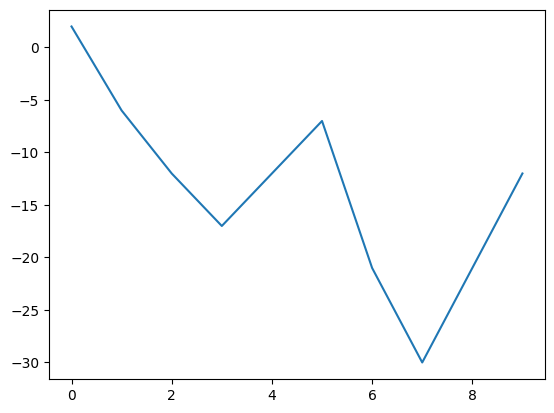

In [20]:
plt.plot(cum_Rew_win)


In [21]:
f = Forest(
    size,
    indiviual_reward_importance,
    social_reward_importance,
    p_change_wind,
    type_plane,
    P_burn,
    P_set_fire,
    P_fire_depend_on_wind,
)
print(f.grid_env)
print(f.grid_type)
agents_2 = Agent(f, gen.make_arch([2, 2, 2]), 1, True)
r_2 = agents_2.live_one_episode()


[[0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [22]:
gen = Genetic(f, 0)
print(gen.train())


[array([[2., 2., 2.],
       [2., 2., 2.],
       [2., 2., 2.]]), array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]]), (13, 9), (0, 0)]
[array([[2., 2., 2.],
       [2., 2., 2.],
       [2., 2., 2.]]), array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]]), (15, 5), (0, 0)]
[array([[0., 2., 2.],
       [2., 2., 2.],
       [0., 0., 0.]]), array([[0., 0., 1.],
       [1., 1., 1.],
       [0., 0., 0.]]), (19, 18), (0, 0)]
[array([[2., 2., 2.],
       [2., 2., 2.],
       [2., 2., 2.]]), array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]]), (12, 8), (6.0, 4.0)]
[array([[2., 2., 2.],
       [2., 2., 2.],
       [2., 2., 2.]]), array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]]), (16, 6), (8.0, 3.0)]
[array([[0., 2., 2.],
       [2., 2., 2.],
       [0., 0., 0.]]), array([[0., 0., 1.],
       [1., 1., 1.],
       [0., 0., 0.]]), (18, 17), (9.0, 8.5)]
[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[1., 1., 1.],
       [1.,

KeyboardInterrupt: 

In [ ]:
f = Forest(size,indiviual_reward_importance,social_reward_importance, p_change_wind, type_plane, P_burn, P_set_fire, P_fire_depend_on_wind)
agents_2 = Agent(f,gen.make_arch([2, 2, 2]), 1,True)
r_2 = agents_2.live_one_episode()
#print("reward of "+str(i)+"th iteration is:" + str(r))
f.reset()


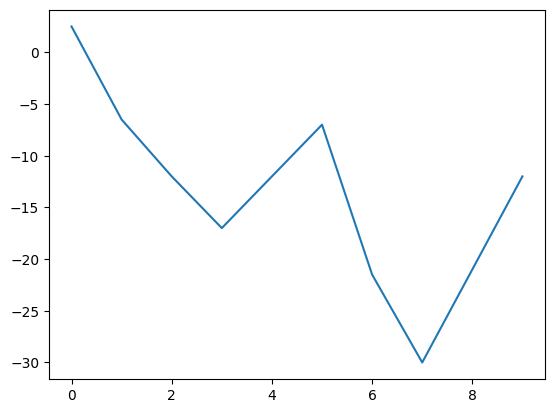

In [23]:
ep_sum = []
for i in r:
  sum = 0 
  for j in range(len(i)):
    sum = np.sum(i[j])
  ep_sum.append(sum)

plt.plot(ep_sum)


In [ ]:
f = Forest(size,indiviual_reward_importance,social_reward_importance, p_change_wind, type_plane, P_burn, P_set_fire, P_fire_depend_on_wind)
g = Genetic(f)
r, agents = main_func(g.make_arch([2, 2, 2]),f)


In [ ]:
for a in agents.all_agents:
  a.save_checkpoint()


In [ ]:
f = Forest(40,indiviual_reward_importance,social_reward_importance, p_change_wind, type_plane, P_burn, P_set_fire, P_fire_depend_on_wind)
g = Genetic(f,0)
r, agents = main_func(g.make_arch([2, 2, 2]),f,1)
for a in agents.all_agents:
  a.save_checkpoint()


In [ ]:
ep_avg = []
for i in r:
  ep_avg.append(np.mean(i))

for x in r:
  print(np.mean(x))
plt.plot(ep_avg)


In [ ]:
plt.ylim([-10, 5])
plt.plot(ep_avg)


In [ ]:
cum_Rew = []
cum_Rew_win = []
k = 1
for i in r:
  sum = 0 
  for j in range(len(i)):
    sum = np.sum(i[j])
    sum = int(sum)
  cum_Rew.append(sum)
  if k > 100 :
    x = np.sum(cum_Rew[k-100:k])
    s = (sum + int(x) )/101
    cum_Rew_win.append(s)
  else:
    cum_Rew_win.append(sum)
  k += 1


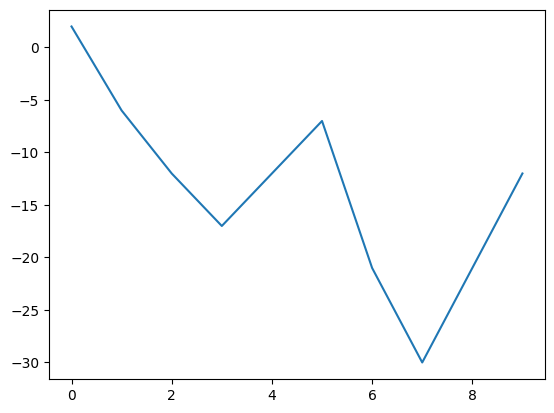

In [24]:
plt.plot(cum_Rew_win)


In [25]:
print(f.grid_env)


[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0. 0. 0. 2. 0. 2. 0. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [26]:
f.terminated()


False

In [27]:
for i in range(10):
    f.init_grid(type_plane)
    f.render([[0,0],[4,4]])
f.save_episode()


video saved


In [28]:
A = np.ones((5,5))
B = np.pad(A, ((2,3),(4,1)))
B


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])